# Coupling From The Past

Our state space will consist of the integers {0, 1, 2, 3, 4} and our transition kernel P as "flip an unbiased coin: if heads, add one (if possible: 4 has an "upper clip" and stays at 4) and if tails, subtract one (if possible: 0 has a "lower clip" and stays at 0)". This chain is ergodic, and the invariant distribution for this chain is the uniform distribution.

In [162]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
S = [0, 1, 2, 3, 4]

P = np.array([(0.5, 0.5, 0.0, 0.0, 0.0),
              (0.5, 0.0, 0.5, 0.0, 0.0),
              (0.0, 0.5, 0.0, 0.5, 0.0),
              (0.0, 0.0, 0.5, 0.0, 0.5),
              (0.0, 0.0, 0.0, 0.5, 0.5)])

pi = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

#Check we have the correct invariant distribution
assert (pi == np.dot(P, pi)).all()


## The Algorithm

We will start with the basic (non-monotone) version of the algorithm, where the random maps are independent.

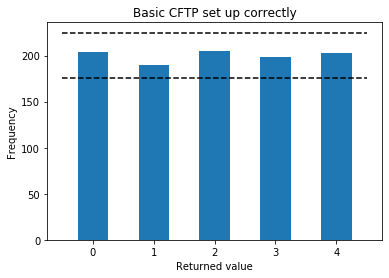

In [163]:
def random_map(seed=None):
    #given a possible starting seed, returns an array mapping elements of S to itself
    
    if seed is not None:
        np.random.seed(seed)
    
    random_numbers = np.random.randint(2, size=5) #five random numbers each 0 or 1 with probability 1/2, independent
    unclipped_map = 2 * random_numbers - 1 + np.array([0, 1, 2, 3, 4])
    clipped_map = np.clip(unclipped_map, 0, 4)
    
    return clipped_map

def compose_map(f_1, f_2):
    #returns the map g corresponding to f2(f1(x)) for x in S
    
    g = np.zeros(5, dtype=np.int)
    
    for i in range(5):
        g[i] = f_2[f_1[i]]
        
    return g

def cftp_basic(seed=None, type='basic'):
    
    if seed is not None:
        np.random.seed(seed)
        
    old_map = np.array([0, 1, 2, 3, 4]) #identity map
    k = 0
    
    if type=='mt':
        while True:
            k = k+1
            new_map = mt_random_map()
            old_map = compose_map(new_map, old_map)

            #check if map is now constant, if so output converged value
            if np.all((old_map - old_map[0])==0):

                return old_map[0]
        

    while True:
        k = k+1
        new_map = random_map()
        old_map = compose_map(new_map, old_map)
        
        #check if map is now constant, if so output converged value
        if np.all((old_map - old_map[0])==0):

            return old_map[0]

N=1000
results = []
for i in range(N):
    results.append(cftp_basic())

plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96 , xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Basic CFTP set up correctly")
plt.xlabel("Returned value")
plt.ylabel("Frequency")
plt.show()


## Coupling to the Future

What happens if we run the algorithm into the future instead? (Swapping the order of composition of maps).

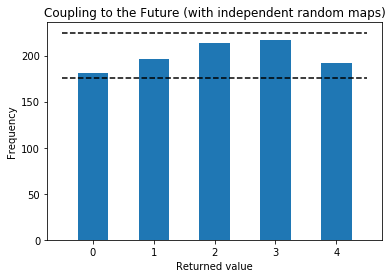

In [164]:
def cftp_future(seed=None, type='basic'):
    
    if seed is not None:
        np.random.seed(seed)
    
    old_map = np.array([0, 1, 2, 3, 4]) #identity map
    k = 0
    
    if type=='mt':
        while True:
            k = k+1
            new_map = mt_random_map()
            old_map = compose_map(old_map, new_map)#swapped composition order

            #check if map is now constant, if so output converged value
            if np.all((old_map - old_map[0])==0):

                return old_map[0]
    
    while True:
        k = k+1
        new_map = random_map()
        old_map = compose_map(old_map, new_map)#swapped composition order
        
        #check if map is now constant, if so output converged value
        if np.all((old_map - old_map[0])==0):

            return old_map[0]
        
N = 1000
results = []
for i in range(N):
    results.append(cftp_future())
    
plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96 , xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Coupling to the Future (with independent random maps)")
plt.xlabel("Returned value")
plt.ylabel("Frequency")
plt.show()

Looks fine, right? This is an artefact of our example. If we instead use the monotone version of random map (instead of drawing 5 random numbers, draw 1 and apply it to all 5 values) we get something very different:

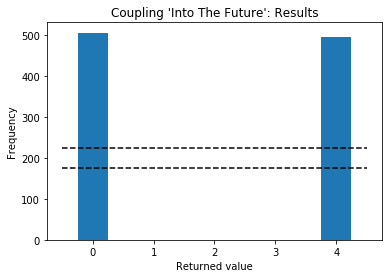

In [165]:
def mt_random_map(seed=None):
    #given a possible starting seed, returns an array mapping elements of S to itself
    
    if seed is not None:
        np.random.seed(seed)
    
    random_numbers = np.full(5, np.random.randint(2)) #five random numbers each 0 or 1 with probability 1/2, all the same
    unclipped_map = 2 * random_numbers - 1 + np.array([0, 1, 2, 3, 4])
    clipped_map = np.clip(unclipped_map, 0, 4)
    
    return clipped_map

N = 1000
results = []
for i in range(N):
    results.append(cftp_future(type='mt'))
    
plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96 , xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Coupling 'Into The Future': Results")
plt.xlabel("Returned value")
plt.ylabel("Frequency")
plt.show()

Since the monotone version of the map can only coalesce at a clip when run into the future, which can only happen at 0 or 4, it clearly cannot approximate pi at all. Compare with the from the past algorithm which is unaffected:

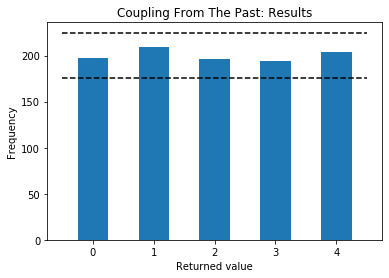

In [166]:
N = 1000
results = []
for i in range(N):
    results.append(cftp_basic(type='mt'))
    
plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96 , xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Coupling From The Past: Results")
plt.xlabel("Returned value")
plt.ylabel("Frequency")
plt.show()

## Monotone CFTP

Say that instead of size n=5, our state space had n very large, so large that computing and storing the n values in each random map at each algortihmic step is prohibitively expensive. We can use the monotone version of the algorithm, which only stores 2 values (though this means it has to restart further and further into the past rather than use backwards composition). Here we have to start being very careful about our seed choices for random numbers.

In [167]:
#Numpy's random functions are well-behaved with respect to seed setting.
np.random.seed(8902)

print(np.random.randint(10, size=5))

np.random.seed(8902)

print(np.random.randint(10, size=10))

[5 7 2 3 9]
[5 7 2 3 9 9 2 9 3 6]


In [168]:
def monotone_cftp_trial(T=1, seed=None):
    '''Runs the algorithm from time -T to time 0 and reports if converged/what to'''
    
    if seed is not None:
        np.random.seed(seed)
    
    random_numbers = 2 * np.random.randint(2, size=T) - 1 #these numbers must be used "in reverse"
    
    one_hat = 4
    zero_hat = 0
    
    for time in range(T, 0, -1):
        U = random_numbers[time-1]
        one_hat = min(max(one_hat+U, 0), 4)
        zero_hat = min(max(zero_hat+U, 0), 4)
        
    converged=(one_hat==zero_hat)
    
    return converged, one_hat, zero_hat
    
def monotone_cftp(seed=None):
    '''Runs the algorithm at successively more negative times with the same starting seed'''
    time = 1
    
    while True:
        trial = monotone_cftp_trial(T=time, seed=seed)
        
        if trial[0]:#convergence has occurred
            return trial[1], time
        time += 1



## Monotone CFTP Results

The version of the algorithm we are using involves increasing the trial time by 1 at each step, rather than doubling it as reccommended in the literature. This is because we want to highlight the effect of the bias created when the algorithm is used incorrectly later in this notebook (bias is reduced when running the Markov chain for extra time). Some observations:

* The algorithm is still giving draws from pi. (See the histogram)
* Although the mean coalescence time is usually quite small, there are lots of outliers on the top end (See the boxplots), indicating a heavy upper tail.
* The coalescence time is not independent of the draw result - for example draws of 2 require two upper clips and two lower clips, which takes more time than four upper clips and zero lower clips.
* This shows that the algorithm is prone to interruptability bias: if you interrupt the algorithm after (in this case) 10 steps without convergence, your results will be biased toward the edges.

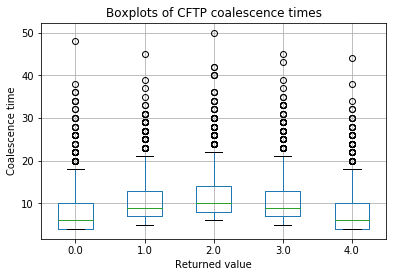

In [169]:
import pandas as pd
N = 10000
df = pd.DataFrame({'times':[], 'draws':[]})
results = []
for i in range(N):
    draw, time = monotone_cftp(i)
    df.loc[i] = [time, draw]
    results.append(draw)

df.boxplot(column='times', by='draws')
plt.title('Boxplots of CFTP coalescence times')
plt.xlabel("Returned value")
plt.ylabel("Coalescence time")
plt.suptitle('')
plt.show()

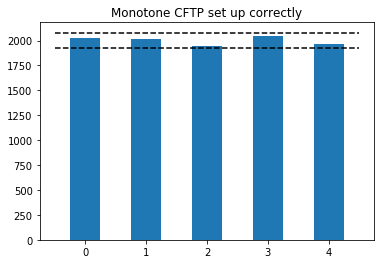

In [170]:

plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96 , xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Monotone CFTP set up correctly")
plt.show()

## Why choosing seeds is important

If you fail to use the same random seed for each trial, you are essentially throwing away results from previous trials rather than extending them. This introduces a bias in the same way as interruptability bias, where results in which the algorithm has a short running time are favoured over those with a long running time:

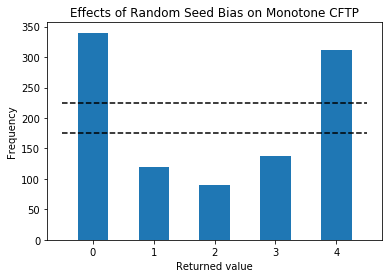

In [171]:
import pandas as pd
N = 1000
df = pd.DataFrame({'times':[], 'draws':[]})
results = []
for i in range(N):
    draw, time = monotone_cftp()
    df.loc[i] = [time, draw]
    results.append(draw)

plt.hist(results, bins=9, range=(-0.25, 4.25))
plt.hlines(y = N/5 + np.array([1, -1])*np.sqrt(N*4/25)*1.96, xmin=-0.5, xmax=4.5, linestyles='dashed') #95% confidence intervals with a Normal approximation
plt.title("Effects of Random Seed Bias on Monotone CFTP")
plt.xlabel("Returned value")
plt.ylabel("Frequency")
plt.show()